<a href="https://colab.research.google.com/github/gitHubAndyLee2020/OpenAI_Gym_Atari_Pong_RL/blob/main/openai_gym_pong_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gym[atari]
!pip install autorom[accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=ca935a07edf952ab231a5d2d3d79b489e3b774ad256a434eb861701cdcd42497
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [ ]:
!pip install pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl


In [ ]:
import numpy as np
import gym
# gym initialization
env = gym.make("Pong-v0")
observation = env.reset()
prev_input = None
# Declaring the two actions that can happen in Pong for an agent, move up or move down
# Decalring 0 means staying still. Note that this is pre-defined specific to package.
UP_ACTION = 2
DOWN_ACTION = 3
# Hyperparameters. Gamma here allows you to measure the effect of future events
gamma = 0.99
# initialization of variables used in the main loop
x_train, y_train, rewards = [],[],[]
reward_sum = 0
episode_nb = 0

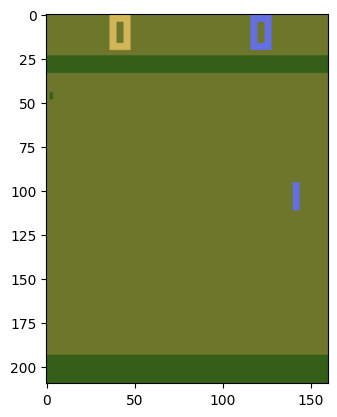

In [ ]:
#Let’s take a look at the game in action.
import matplotlib.pyplot as plt
env = gym.make("Pong-v0") # environment info
observation = env.reset()
# The ball is released after 20 frames
for i in range(22):
  if i > 20:
    plt.imshow(observation)
    plt.show()
observation, _, _, _ = env.step(1)

<ipython-input-55-360e2c46470b>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


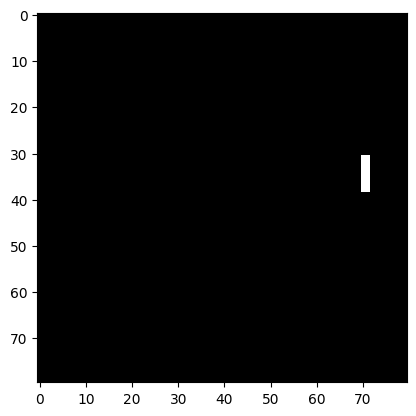

In [ ]:
def prepro(I):
  """prepro 210x160x3 frame into 6400 (80x80) 1D float vector"""
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()
#Show preprocessed
obs_preprocessed = prepro(observation).reshape(80,80)
plt.imshow(obs_preprocessed, cmap='gray')
plt.show()

In [ ]:
def discount_rewards(r, gamma):
  """take 1D float array of rewards and compute discounted reward"""
  r = np.array(r)
  discounted_r = np.zeros_like(r)
  running_add = 0

  for t in reversed(range(0, r.size)):
    if r[t] != 0:
      running_add = 0 # if the game ended (in Pong), reset
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add

  discounted_r -= np.mean(discounted_r) #normalizing the result
  discounted_r /= np.std(discounted_r) #idem using standar deviation
  return discounted_r

In [ ]:
# import necessary modules from keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
import tensorflow.keras
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.optimizers import Adam
"""
The 80 * 80 input dimension comes from the pre-processing of the raw pixels made by Karpathy (the only important pixels are the balls and the paddle)
Input here represents the difference in pixels betewen one frame and another, giving you direction of agents and ball. Encoded in Karpathy’s own preprocessing functions
"""

model = Sequential()
# hidden layer takes a pre-processed frame as input, and has 200 units. Simple layer architectur of 200 x1, 1x1
model.add(Dense(units=200,input_dim=80*80, activation='relu', kernel_initializer='glorot_uniform'))
# output layer — we use a Sigmoid here, in order to get a 0, or 1 value to represent ACTION UP
model.add(Dense(units=1, activation='sigmoid', kernel_initializer='RandomNormal'))
# compile the model using traditional Machine Learning losses and optimizers
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 200)               1280200   
                                                                 
 dense_9 (Dense)             (None, 1)                 201       
                                                                 
Total params: 1280401 (4.88 MB)
Trainable params: 1280401 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
num_epochs = 50

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def print_epochs(epochs):
  print("==================================================")
  print(f"Epochs: {epochs}")
  print("==================================================")

history = []
observation = env.reset()
prev_input = None
epochs = 0
# main training loop
print_epochs(epochs)
while (True):
  if epochs == num_epochs:
    break

  cur_input = prepro(observation)
  #print(len(cur_input)) — Sanity Check reasons only

  x = cur_input - prev_input if prev_input is not None else np.zeros(80 * 80)
  prev_input = cur_input

  # forward the policy network and sample action according to the probability distribution

  proba = model.predict(np.expand_dims(x, axis=1).T)


  action = UP_ACTION if np.random.uniform() < proba else DOWN_ACTION
  y = 1 if action == 2 else 0 # 0 and 1 are our labels
  # log the input and label to train later
  x_train.append(x)
  y_train.append(y)
  # do one step in our environment - This is returned by our environment in OpenAI gym.
  observation, reward, done, info = env.step(action)

  rewards.append(reward)
  reward_sum += reward

  if done:
    history.append(reward_sum)
    print('At the end of episode', episode_nb, 'the total reward was :', reward_sum)
    epochs += 1
    print_epochs(epochs)
    if episode_nb>=3000 and reward_sum >=-12:
      break
    else:

      # increment episode number
      episode_nb += 1

      # training
      model.fit(x=np.vstack(x_train), y=np.vstack(y_train), verbose=1, sample_weight=discount_rewards(rewards, gamma))


      # Reinitialization
      x_train, y_train, rewards = [],[],[]
      observation = env.reset()
      reward_sum = 0
      prev_input = None

Epochs: 0
1/1 [==============================] - 0s 18ms/step


<ipython-input-55-360e2c46470b>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 17ms/step
At the end of episode 46 the total reward was : -21.0
Epochs: 47
1/1 [==============================] - 0s 19ms/step
At the end of episode 47 the total reward was : -19.0
Epochs: 48
1/1 [==============================] - 0s 19ms/step
At the end of episode 48 the total reward was : -21.0
Epochs: 49
1/1 [==============================] - 0s 17ms/step
At the end of episode 49 the total reward was : -21.0
Epochs: 50
45/45 [==============================] - 0s 3ms/step - loss: 0.0159 - accuracy: 0.7930


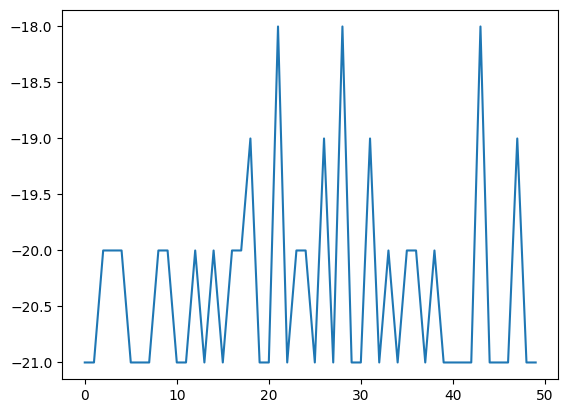

In [ ]:
plt.plot(history)
plt.show()

In [ ]:
model.save(f'pong_epochs_{num_epochs}.h5')

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model(f'pong_epochs_{num_epochs}.h5')

In [ ]:
!apt-get install xvfb
!pip install xvfbwrapper

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 18 not upgraded.
Need to get 7,812 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")
def wrap_env(env):
  env = RecordVideo(env, './video')
  return env
#Evaluate model on openAi GYM
#To do this consult https://github.com/thinkingparticle/deep_rl_pong_keras/blob/master/reinforcement_learning_pong_keras_policy_gradients.ipynb
env = wrap_env(gym.make('Pong-v0'))
observation = env.reset()
new_observation = observation
prev_input = None
done = False
while True:
  if True:

    #set input to network to be difference image

    cur_input = prepro(observation)
    x = cur_input - prev_input if prev_input is not None else np.zeros(80 * 80)
    prev_input = cur_input

    # Sample an action (policy)
    proba = model.predict(np.expand_dims(x, axis=1).T)
    action = UP_ACTION if np.random.uniform() < proba else DOWN_ACTION

    env.render()
    # Return action to environment and extract
    #next observation, reward, and status
    observation = new_observation
    new_observation, reward, done, info = env.step(action)
    if done:
      #observation = env.reset()
      break

env.close()
show_video()

1/1 [==============================] - 0s 17ms/step


<ipython-input-55-360e2c46470b>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


1/1 [==============================] - 0s 17ms/step
